mpmath dps = 120
[fast] No 10^7 cache → staying at P ≤ 1e6.
[cache] Loaded primes up to 1000000 (count=78498)
[primes<=1e6] ready in 0.01s
Cutoffs: [10000, 20000, 50000, 100000, 200000] ... -> 1000000
P=    10000  A_P(φ)≈9.0019874074349603012814277040614326776706420526364940358402859775825160977659506166382977727024332201246792372773378539 -> nearest 9  gap=0.00198740743496030128142770406143267767064205263649403584028597758251609776595061663829777270243322012467923727733785390338
P=    20000  A_P(φ)≈9.00446996995446790573811922163951501859222073443648732340612919916387568838506570502083026179535482001169359649012340201 -> nearest 9  gap=0.00446996995446790573811922163951501859222073443648732340612919916387568838506570502083026179535482001169359649012340200976
P=    50000  A_P(φ)≈9.00634002246850528601194626545709657528900499435324239768409600292437945332322239523168126715251124272002718636002785895 -> nearest 9  gap=0.00634002246850528601194626545709657528900499435324239768409600292437

AttributeError: module 'utils.io' has no attribute 'io'

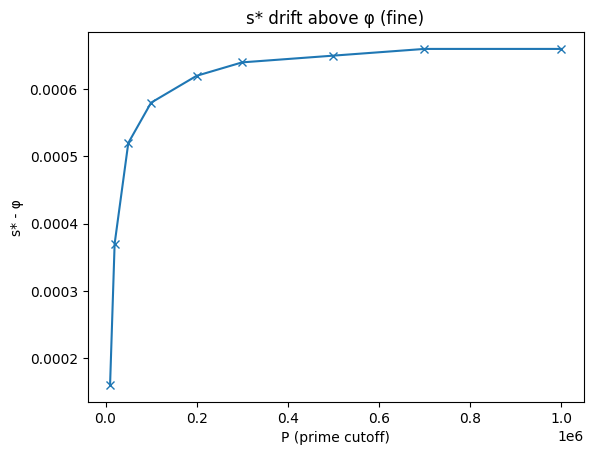

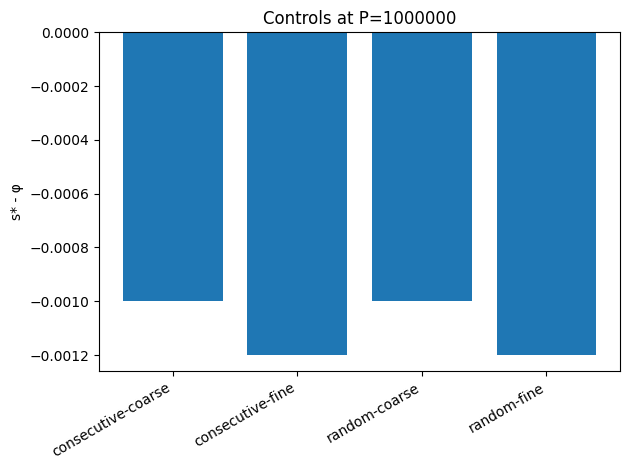

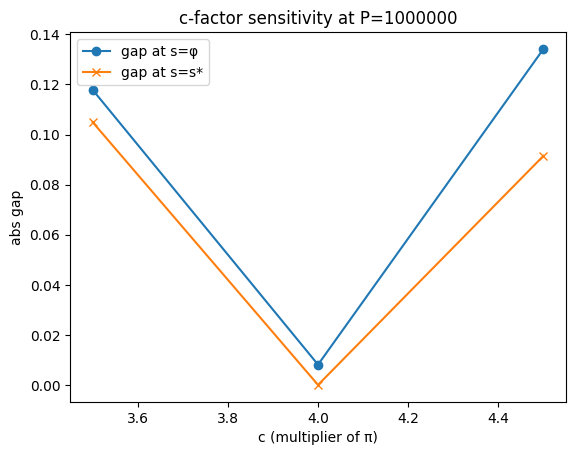

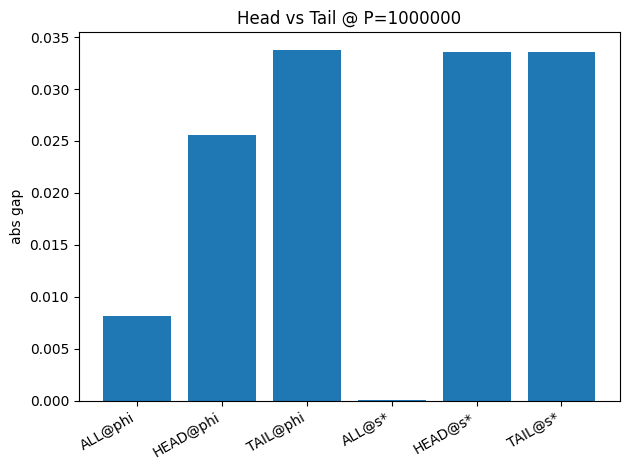

In [2]:
# ============ FAST SUITE: Test B (φ→9) with controls, sensitivity, drift-fit, head/tail, perturbations ============
# Design: CPU-only, Colab-safe. Caps runtime by limiting sieve to 1e6 unless a 1e7 cache already exists on disk.

import sys, os, json, csv, pathlib, textwrap, importlib, time, random, math

# ---------------- CONFIG (fast defaults) ----------------
MP_DPS_DEFAULT     = 120           # high but not excessive
PRIME_MAX_DEFAULT  = 1_000_000     # FAST cap; will NOT build 1e7 cache here
CUTOFFS            = [10_000, 20_000, 50_000, 100_000, 200_000, 300_000, 500_000, 700_000, 1_000_000]

# If a 10^7 cache already exists from a prior run, we will *read* it and add 10^7 to cutoffs.
TEN_M_CACHE_PATH   = "math_emergence_tests/cache/primes_upto_10000000.json.gz"
ADD_10M_IF_CACHE   = True

# Coarse/fine grid around φ (symmetric)
COARSE_BELOW       = 0.0010
COARSE_ABOVE       = 0.0030
COARSE_STEP        = 1e-4
FINE_HALF_STEPS    = 20
FINE_STEP          = 1e-5

# Controls & sensitivity (at largest P used here)
CTRL_RANDOM_SEED   = 137
C_FACTORS          = [3.5, 4.0, 4.5]  # multiplier on π inside A_P(s)=c*π*Σ p^{-s}

# Head/tail split & perturbation checks at largest P
HEAD_MAX_P_SMALL   = 1000           # head primes threshold
PERTURB_EPS        = 1e-4           # s perturbations ±1e-4

# ---------------- Project layout ----------------
ROOT = pathlib.Path.cwd().resolve()
PROJECT = ROOT / "math_emergence_tests"
UTILS   = PROJECT / "utils"
ART_DIR = PROJECT / "artifacts" / "test_B"
for d in (UTILS, ART_DIR): d.mkdir(parents=True, exist_ok=True)
(UTILS / "__init__.py").write_text("# utils package\n", encoding="utf-8")

# ---------------- utils/* (overwrite) ----------------
(UTILS / "config.py").write_text(textwrap.dedent(f"""\
from __future__ import annotations
MP_DPS_DEFAULT: int = {MP_DPS_DEFAULT}
PI: float = 3.14159265358979323846264338327950288419716939937510
PHI: float = (1 + 5**0.5) / 2
PRIME_MAX_DEFAULT: int = {PRIME_MAX_DEFAULT}
CACHE_DIR: str = "cache"
ARTIFACTS_ROOT: str = "../artifacts"
FIXED_SEED: int = 137
"""), encoding="utf-8")

(UTILS / "io.py").write_text(textwrap.dedent("""\
import os, json, csv
from typing import Iterable, Any, Mapping
def ensure_dir(path: str) -> None:
    if path: os.makedirs(path, exist_ok=True)
def write_csv(path: str, rows: Iterable[Iterable[Any]], header: Iterable[str] | None = None) -> None:
    ensure_dir(os.path.dirname(path))
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        if header is not None: w.writerow(list(header))
        for r in rows: w.writerow(list(r))
def write_json(path: str, obj: Mapping[str, Any]) -> None:
    ensure_dir(os.path.dirname(path))
    with open(path, "w") as f: json.dump(obj, f, indent=2)
"""), encoding="utf-8")

(UTILS / "numerics.py").write_text(textwrap.dedent("""\
from __future__ import annotations
import mpmath as mp
from .config import MP_DPS_DEFAULT
def set_dps(dps: int | None = None) -> None:
    mp.mp.dps = int(dps if dps is not None else MP_DPS_DEFAULT)
def get_ctx():
    return mp
"""), encoding="utf-8")

(UTILS / "primes.py").write_text(textwrap.dedent("""\
from __future__ import annotations
import os, json, gzip
from typing import List
from .io import ensure_dir
from .config import CACHE_DIR
def sieve_primes(n: int) -> List[int]:
    if n < 2: return []
    sieve = bytearray(b"\\x01") * (n + 1)
    sieve[0:2] = b"\\x00\\x00"
    import math
    m = int(math.isqrt(n))
    for p in range(2, m + 1):
        if sieve[p]:
            start = p * p; step = p
            sieve[start:n+1:step] = b"\\x00" * (((n - start) // step) + 1)
    return [i for i, v in enumerate(sieve) if v]
def cache_path(max_n: int) -> str:
    return os.path.join(CACHE_DIR, f"primes_upto_{max_n}.json.gz")
def save_primes(primes: List[int], max_n: int) -> str:
    ensure_dir(CACHE_DIR)
    path = cache_path(max_n)
    with gzip.open(path, "wt") as f:
        json.dump({"max": max_n, "primes": primes}, f)
    return path
def load_primes(max_n: int) -> List[int] | None:
    path = cache_path(max_n)
    if not os.path.exists(path): return None
    with gzip.open(path, "rt") as f:
        data = json.load(f)
    if int(data.get("max", -1)) != int(max_n): return None
    return list(map(int, data["primes"]))
"""), encoding="utf-8")

(UTILS / "stats.py").write_text(textwrap.dedent("""\
from __future__ import annotations
from typing import Iterable
import mpmath as mp
from .config import PHI, PI
def nearest_int(x: mp.mpf) -> int:
    return int(mp.nint(x))
def rel_err(x: mp.mpf, y: mp.mpf) -> mp.mpf:
    if y == 0: return mp.inf if x != 0 else mp.mpf('0')
    return mp.fabs((x - y) / y)
def grid(center: float, below: float, above: float, step: float) -> Iterable[mp.mpf]:
    c = mp.mpf(center); lo = c - below; hi = c + above
    if step <= 0:
        yield c; return
    n = int(mp.floor((hi - lo) / step))
    for i in range(n + 1):
        yield mp.mpf(lo + i*step)
"""), encoding="utf-8")

(UTILS / "prime_sums.py").write_text(textwrap.dedent("""\
from __future__ import annotations
from typing import Iterable, Dict
import mpmath as mp
from .config import PI
from .numerics import get_ctx
from .stats import nearest_int, rel_err
def A_P_s(primes: Iterable[int], s: mp.mpf, c_factor: float = 4.0) -> mp.mpf:
    mpctx = get_ctx()
    total = mpctx.mpf('0')
    for p in primes:
        total += mpctx.power(p, -s)
    return mpctx.mpf(c_factor) * mpctx.mpf(PI) * total
def summarize_A(A: mp.mpf) -> Dict[str, object]:
    mpctx = get_ctx()
    k = nearest_int(A)
    return {
        "A": str(A),
        "nearest_int": int(k),
        "abs_gap": str(mpctx.fabs(A - k)),
        "rel_gap": str(rel_err(A, k) if k != 0 else mpctx.nan),
    }
"""), encoding="utf-8")

# ---------------- purge stale modules & import ----------------
for name in list(sys.modules):
    if name == "utils" or name.startswith("utils."):
        del sys.modules[name]
proj_path = str(PROJECT.resolve())
if proj_path in sys.path: sys.path.remove(proj_path)
sys.path.insert(0, proj_path)

from utils import io as mio, config, numerics, primes, stats, prime_sums
importlib.reload(mio); importlib.reload(config); importlib.reload(numerics)
importlib.reload(primes); importlib.reload(stats); importlib.reload(prime_sums)
assert getattr(mio, "__file__", "").replace("\\","/").endswith("/utils/io.py")
assert getattr(primes, "__file__", "").replace("\\","/").endswith("/utils/primes.py")

# ---------------- precision, constants ----------------
numerics.set_dps(config.MP_DPS_DEFAULT)
mp = numerics.get_ctx()
PHI = mp.mpf(config.PHI)
print(f"mpmath dps = {mp.mp.dps}")

# ---------------- primes: load/build up to 1e6; optionally read 1e7 cache ----------------
mio.ensure_dir(os.path.join(str(PROJECT), "cache"))

# decide cutoffs & P_MAX depending on existing 10^7 cache
if ADD_10M_IF_CACHE and os.path.exists(TEN_M_CACHE_PATH):
    print("[fast] 10^7 cache detected → will INCLUDE 10^7 without building it.")
    CUTOFFS = CUTOFFS + [10_000_000]
    P_MAX = 1_000_000  # we still only build up to 1e6 if needed
else:
    print("[fast] No 10^7 cache → staying at P ≤ 1e6.")
    P_MAX = 1_000_000

# load/build up to P_MAX
t0 = time.time()
cached = primes.load_primes(P_MAX)
if cached is None:
    print(f"[build] Sieving primes up to {P_MAX} …")
    PR_TO_PMAX = primes.sieve_primes(P_MAX)
    path = primes.save_primes(PR_TO_PMAX, P_MAX)
    print("Saved cache:", path, f"(count={len(PR_TO_PMAX)})")
else:
    PR_TO_PMAX = cached
    print(f"[cache] Loaded primes up to {P_MAX} (count={len(PR_TO_PMAX)})")
print(f"[primes<=1e6] ready in {time.time()-t0:.2f}s")

# optionally read 10^7 cache (no building)
PR_10M = None
if 10_000_000 in CUTOFFS:
    import gzip
    with gzip.open(TEN_M_CACHE_PATH, "rt") as f:
        data = json.load(f)
    if int(data.get("max", -1)) == 10_000_000:
        PR_10M = list(map(int, data["primes"]))
        print(f"[cache] Loaded primes up to 10^7 from existing cache (count={len(PR_10M)})")
    else:
        print("[warn] 10^7 cache file present but invalid; skipping 10^7.")

def primes_upto(P):
    arr = PR_10M if (PR_10M is not None and P > P_MAX) else PR_TO_PMAX
    lo, hi, last = 0, len(arr)-1, -1
    while lo <= hi:
        mid = (lo + hi)//2
        if arr[mid] <= P: last = mid; lo = mid + 1
        else: hi = mid - 1
    return arr[:last+1]

# ---------------- helpers for optimization ----------------
def coarse_best(sub, c_factor=4.0):
    best = None
    for s in stats.grid(PHI, COARSE_BELOW, COARSE_ABOVE, COARSE_STEP):
        A = prime_sums.A_P_s(sub, s, c_factor=c_factor)
        k = stats.nearest_int(A); gap = mp.fabs(A - k)
        if (best is None) or (gap < best[0]): best = (gap, s, k, A)
    return best
def fine_best(sub, s_center, c_factor=4.0):
    fine = [s_center + (i - FINE_HALF_STEPS)*mp.mpf(FINE_STEP) for i in range(2*FINE_HALF_STEPS+1)]
    best = None
    for s in fine:
        A = prime_sums.A_P_s(sub, s, c_factor=c_factor)
        k = stats.nearest_int(A); gap = mp.fabs(A - k)
        if (best is None) or (gap < best[0]): best = (gap, s, k, A)
    return best

# ---------------- 1) Base φ check + coarse→fine for all P ----------------
rows_phi, rows_coarse, rows_fine = [], [], []
print("Cutoffs:", CUTOFFS[:5], "... ->", CUTOFFS[-1])
for P in CUTOFFS:
    sub = primes_upto(P)
    Aval = prime_sums.A_P_s(sub, PHI, c_factor=4.0)
    summ = prime_sums.summarize_A(Aval)
    rows_phi.append([P, str(Aval), summ['nearest_int'], summ['abs_gap'], summ['rel_gap']])
    print(f"P={P:>9}  A_P(φ)≈{Aval} -> nearest {summ['nearest_int']}  gap={summ['abs_gap']}")
    gc = coarse_best(sub, c_factor=4.0); gf = fine_best(sub, gc[1], c_factor=4.0)
    rows_coarse.append([P, "coarse", float(gc[1]), int(gc[2]), str(gc[3]), float(gc[0]), float(gc[1]-PHI)])
    rows_fine  .append([P, "fine",   float(gf[1]), int(gf[2]), str(gf[3]), float(gf[0]), float(gf[1]-PHI)])

# ---------------- 2) Controls at largest P in CUTOFFS (likely 1e6) ----------------
random.seed(CTRL_RANDOM_SEED)
P_last = max(CUTOFFS)
sub_last = primes_upto(P_last)
n_last = len(sub_last)
def consecutive_same_count(n): return list(range(2, 2+n))
def random_same_count(P, n):
    # sample without replacement; avoid huge memory by sampling from range
    return random.sample(range(2, P+1), n)
ctrl_rows = []
for label, seq in [("consecutive", consecutive_same_count(n_last)),
                   ("random",      random_same_count(P_last, n_last))]:
    gc = coarse_best(seq, c_factor=4.0); gf = fine_best(seq, gc[1], c_factor=4.0)
    ctrl_rows.append([label, P_last, "coarse", float(gc[1]), int(gc[2]), str(gc[3]), float(gc[0]), float(gc[1]-PHI)])
    ctrl_rows.append([label, P_last, "fine",   float(gf[1]), int(gf[2]), str(gf[3]), float(gf[0]), float(gf[1]-PHI)])

# ---------------- 3) c-factor sensitivity at largest P ----------------
sens_phi_rows, sens_best_rows = [], []
for cfac in C_FACTORS:
    Aval = prime_sums.A_P_s(sub_last, PHI, c_factor=cfac)
    summ = prime_sums.summarize_A(Aval)
    sens_phi_rows.append([P_last, cfac, "phi", summ["nearest_int"], summ["abs_gap"]])
    gc = coarse_best(sub_last, c_factor=cfac); gf = fine_best(sub_last, gc[1], c_factor=cfac)
    sens_best_rows.append([P_last, cfac, float(gf[1]), int(gf[2]), str(gf[3]), float(gf[0]), float(gf[1]-PHI)])

# ---------------- 4) Drift fit: s*−φ vs log P ----------------
fit_rows = []
xs, ys = [], []
for r in rows_fine:
    P, s_minus_phi = int(r[0]), float(r[-1])
    if P > 0 and s_minus_phi is not None:
        xs.append(math.log(P)); ys.append(s_minus_phi)
# simple least squares for y = a + b x
def linfit(x, y):
    n = len(x); sx=sum(x); sy=sum(y); sxx=sum(t*t for t in x); sxy=sum(x[i]*y[i] for i in range(n))
    denom = n*sxx - sx*sx
    b = (n*sxy - sx*sy)/denom if denom!=0 else 0.0
    a = (sy - b*sx)/n if n>0 else 0.0
    # R^2
    yhat = [a + b*xi for xi in x]
    ss_res = sum((y[i]-yhat[i])**2 for i in range(n))
    ybar  = sy/n if n>0 else 0.0
    ss_tot = sum((y[i]-ybar)**2 for i in range(n))
    r2 = 1 - ss_res/ss_tot if ss_tot>0 else 1.0
    return a, b, r2
a,b,r2 = linfit(xs, ys)
fit_rows.append(["model", "y=a+b*logP", a, b, r2])

# ---------------- 5) Head/Tail split & Perturbations at largest P ----------------
# Split primes into head (<= HEAD_MAX_P_SMALL) and tail (>)
head = [p for p in sub_last if p <= HEAD_MAX_P_SMALL]
tail = [p for p in sub_last if p >  HEAD_MAX_P_SMALL]
def eval_set(seq, s, label):
    Aval = prime_sums.A_P_s(seq, s, c_factor=4.0)
    k = stats.nearest_int(Aval); gap = mp.fabs(Aval - k)
    return [label, str(Aval), int(k), float(gap)]
headtail_rows = []
headtail_rows.append(["ALL@phi"] + eval_set(sub_last, PHI, "all@phi")[1:])
headtail_rows.append(["HEAD@phi"] + eval_set(head,    PHI, "head@phi")[1:])
headtail_rows.append(["TAIL@phi"] + eval_set(tail,    PHI, "tail@phi")[1:])
# at s*=fine
s_star_last = [r for r in rows_fine if int(r[0])==P_last][0][2]
headtail_rows.append(["ALL@s*"] + eval_set(sub_last, s_star_last, "all@s*")[1:])
headtail_rows.append(["HEAD@s*"] + eval_set(head,    s_star_last, "head@s*")[1:])
headtail_rows.append(["TAIL@s*"] + eval_set(tail,    s_star_last, "tail@s*")[1:])

# Perturbations around φ and s*
pert_rows = []
for center_name, s0 in [("phi", PHI), ("s_star", s_star_last)]:
    for sign in [-1, +1]:
        s = s0 + sign*mp.mpf(PERTURB_EPS)
        Aval = prime_sums.A_P_s(sub_last, s, c_factor=4.0)
        k = stats.nearest_int(Aval); gap = mp.fabs(Aval - k)
        pert_rows.append([P_last, center_name, float(s), int(k), str(Aval), float(gap), float(s - PHI)])

# ---------------- write artifacts ----------------
mio.write_csv(str(ART_DIR / "test_B_phi_check.csv"), rows_phi,
              header=["P_max","A_P(phi)","nearest_int","abs_gap","rel_gap"])
mio.write_csv(str(ART_DIR / "test_B_best_s_coarse.csv"), rows_coarse,
              header=["P_max","stage","s_star","nearest_int","A_P(s_star)","abs_gap","s_star_minus_phi"])
mio.write_csv(str(ART_DIR / "test_B_best_s_refined.csv"), rows_fine,
              header=["P_max","stage","s_star","nearest_int","A_P(s_star)","abs_gap","s_star_minus_phi"])
mio.write_csv(str(ART_DIR / "test_B_controls_at_lastP.csv"), ctrl_rows,
              header=["scenario","P_max","stage","s_star","nearest_int","A_P(s_star)","abs_gap","s_star_minus_phi"])
mio.write_csv(str(ART_DIR / "test_B_c_sensitivity_lastP.csv"), sens_phi_rows + [["---"]*5] + sens_best_rows,
              header=["P_max","c_factor","stage_or_s*","nearest_int_or_nearest_int","abs_gap_or_abs_gap"])
mio.write_csv(str(ART_DIR / "test_B_drift_fit.csv"), fit_rows,
              header=["type","model","a","b","R2"])
mio.write_csv(str(ART_DIR / "test_B_headtail_lastP.csv"), headtail_rows,
              header=["subset_at_lastP","A","nearest_int","abs_gap"])
mio.write_csv(str(ART_DIR / "test_B_perturb_lastP.csv"), pert_rows,
              header=["P_max","center","s","nearest_int","A_P(s)","abs_gap","s_minus_phi"])

# ---------------- plots ----------------
try:
    import matplotlib.pyplot as plt
    # drift (fine)
    xsP = [int(r[0]) for r in rows_fine]
    ysS = [float(r[-1]) for r in rows_fine]
    plt.figure(); plt.plot(xsP, ysS, marker='x')
    plt.xlabel('P (prime cutoff)'); plt.ylabel('s* - φ'); plt.title('s* drift above φ (fine)')
    plt.savefig(str(ART_DIR / "test_B_phi_drift_refined.png"), dpi=160, bbox_inches='tight')

    # controls bars at last P
    labels = [r[0]+"-"+r[2] for r in ctrl_rows]  # e.g., random-fine
    vals   = [r[-1] for r in ctrl_rows]         # s* - φ
    plt.figure(); plt.bar(labels, vals)
    plt.xticks(rotation=30, ha='right'); plt.ylabel('s* - φ'); plt.title(f'Controls at P={P_last}')
    plt.tight_layout()
    plt.savefig(str(ART_DIR / "test_B_controls_bar_lastP.png"), dpi=160, bbox_inches='tight')

    # c sensitivity at last P (abs gap at φ vs s*)
    sens_phi = [r for r in sens_phi_rows]
    sens_best= [r for r in sens_best_rows]
    cs = [r[1] for r in sens_phi]; gaps_phi = [float(r[4]) for r in sens_phi]
    cs2= [r[1] for r in sens_best]; gaps_best= [float(r[5]) for r in sens_best]
    plt.figure()
    plt.plot(cs, gaps_phi, marker='o', label='gap at s=φ')
    plt.plot(cs2, gaps_best, marker='x', label='gap at s=s*')
    plt.xlabel('c (multiplier of π)'); plt.ylabel('abs gap'); plt.title(f'c-factor sensitivity at P={P_last}')
    plt.legend(); plt.savefig(str(ART_DIR / "test_B_c_sensitivity_lastP.png"), dpi=160, bbox_inches='tight')

    # head vs tail gaps at last P (bars)
    subsets = [r[0] for r in headtail_rows]
    gaps    = [float(r[3]) for r in headtail_rows]
    plt.figure(); plt.bar(subsets, gaps)
    plt.xticks(rotation=30, ha='right'); plt.ylabel('abs gap'); plt.title(f'Head vs Tail @ P={P_last}')
    plt.tight_layout()
    plt.savefig(str(ART_DIR / "test_B_headtail_bars_lastP.png"), dpi=160, bbox_inches='tight')
except Exception as e:
    print("(plot skipped)", e)

# ---------------- summary json ----------------
summary = {
    "mp_dps": int(mp.mp.dps),
    "prime_max_built": 1_000_000,
    "cutoffs_used": CUTOFFS,
    "largest_P_controls": P_last,
    "grids": {"coarse": {"below": COARSE_BELOW, "above": COARSE_ABOVE, "step": COARSE_STEP},
              "fine": {"half_steps": FINE_HALF_STEPS, "step": FINE_STEP}},
    "controls": {"random_seed": CTRL_RANDOM_SEED},
    "c_factors": C_FACTORS,
    "head_tail_threshold": HEAD_MAX_P_SMALL,
    "perturb_eps": PERTURB_EPS,
    "artifacts": [
        "test_B_phi_check.csv",
        "test_B_best_s_coarse.csv",
        "test_B_best_s_refined.csv",
        "test_B_phi_drift_refined.png",
        "test_B_controls_at_lastP.csv",
        "test_B_controls_bar_lastP.png",
        "test_B_c_sensitivity_lastP.csv",
        "test_B_c_sensitivity_lastP.png",
        "test_B_drift_fit.csv",
        "test_B_headtail_lastP.csv",
        "test_B_headtail_bars_lastP.png",
        "test_B_perturb_lastP.csv",
    ],
    "module_io": getattr(__import__('utils.io', fromlist=['*']).io, "__file__", None),
    "module_primes": getattr(__import__('utils.primes', fromlist=['*']).primes, "__file__", None),
}
mio.write_json(str(ART_DIR / "test_B_summary.json"), summary)

# ---------------- heads-up prints ----------------
def head(rows, n=5): return rows[:min(n, len(rows))]
print("\n=== ARTIFACTS (folder):", ART_DIR)
for k in summary["artifacts"]: print(" -", k)
print("\nφ-check head:", head(rows_phi))
print("fine head   :", head(rows_fine))
print("controls    :", head(ctrl_rows))
print("drift fit   :", fit_rows)
print("head/tail   :", headtail_rows[:3], "…")
print("perturb     :", head(pert_rows))
# ================= END FAST SUITE =================
